In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [82]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
y, tX, ids, headers = load_csv_data(DATA_TRAIN_PATH)

In [12]:
import seaborn as sns

def correlation_plot(x, h):
    corr = np.corrcoef(x.T)
    fig, ax = plt.subplots(figsize=(10,10))

# Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, cmap=sns.diverging_palette(20, 220, n=200), center=0,
                square=True, linewidths=.2, cbar_kws={"shrink": .5}, ax=ax)
    ax.set_xticks(np.arange(len(h))+0.5)
    ax.set_yticks(np.arange(len(h))+0.5)

    ax.set_xticklabels(h, rotation=90);
    ax.set_yticklabels(h, rotation=0);
    ax.set_ylim(-1,31);


## Do your thing crazy machine learning thing here :) ...

#### Studying the distribution of variables to detect possible categorical or faulty values

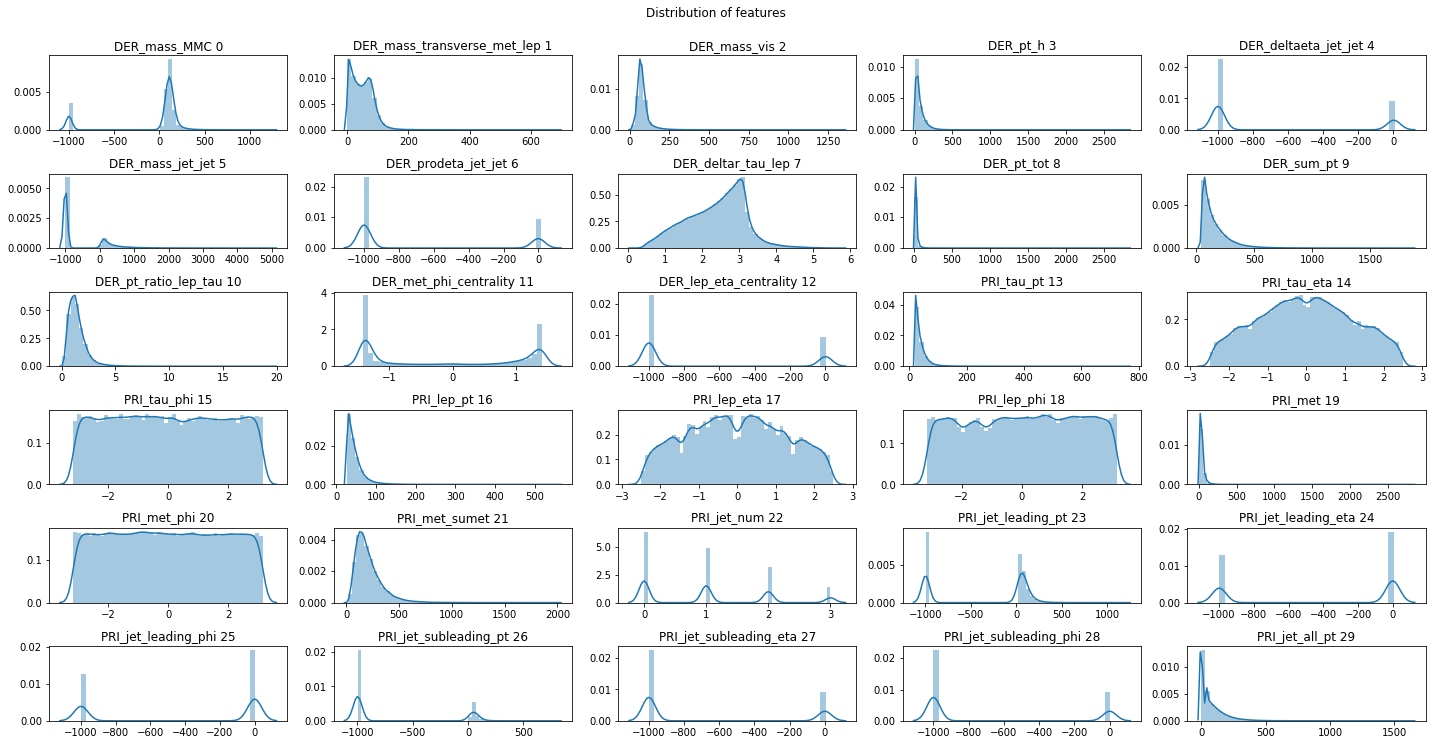

In [13]:
from plots import plot_feature_distribution
plot_feature_distribution(tX, headers, np.arange(len(headers)), "Distribution of features", 5, 6)

As we can see from these plots, different features have different distributions. We can also notice that there seems to be one categorical feature, namely `PRI_jet_num`. This feature is the number of jets used during the experiment. If we look at the documentation of the dataset (https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf), we can see that some feature are actually affected by the number of jets used.

Features affected by undefined values:
- `DER_mass_MMC` ID=0: undefined if topology of event too far from expected
- `DER_deltaeta_jet_jet` ID=4 : undefined if `PRI_jet_num` <= 1
- `DER_mass_jet_jet` ID=5: undefined if `PRI_jet_num` <= 1
- `DER_prodeta_jet_jet` ID=6: undefined if `PRI_jet_num` <= 1
- `DER_lep_eta_centrality` ID=12: undefined if `PRI_jet_num` <= 1
- `PRI_jet_leading_pt` ID=23: undefined if `PRI_jet_num` == 0
- `PRI_jet_leading_eta` ID=24: undefined if `PRI_jet_num` == 0
- `PRI_jet_leading_phi` ID=25: undefined if `PRI_jet_num` == 0
- `PRI_jet_subleading_pt` ID=26: undefined if `PRI_jet_num` <= 1
- `PRI_jet_subleading_eta` ID=27: undefined if `PRI_jet_num` <= 1
- `PRI_jet_subleading_phi` ID=28: undefined if `PRI_jet_num` <= 1

Hence, it might be a good idea to have estimators for each number of jets (0, 1, and more than 1).
Also, we can see that features `PRI_tau_phi`, `PRI_lep_phi` and `PRI_met_phi` have an almost uniform distribution. Let us look at the distribution of those features that are undefined at some point.

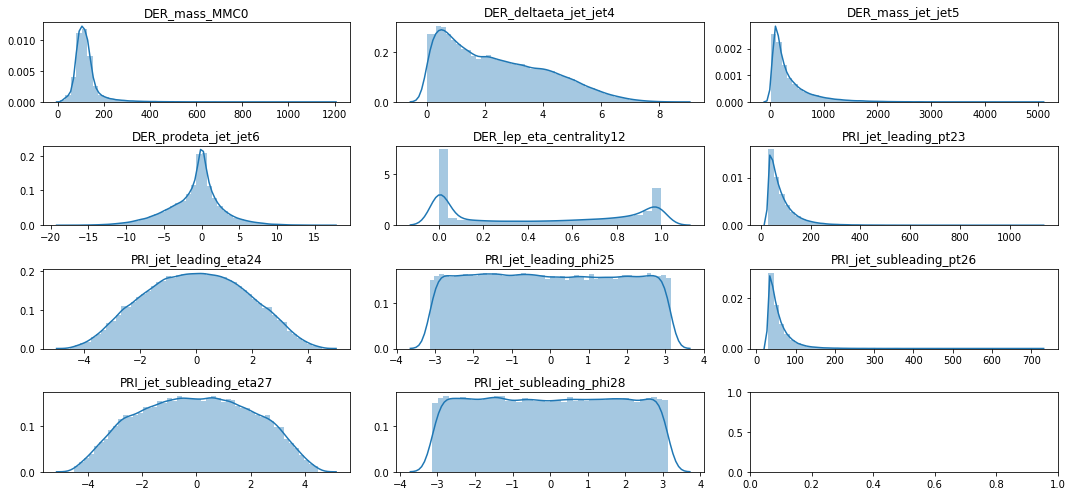

In [83]:
from plots import plot_undefined_features, plot_feature_distribution
plot_undefined_features(tX, headers)

As we can see, there are 5 features (let's call the the `PHI` features) that have a uniform distribution. We can discard those, as they do not bring us any additional information.

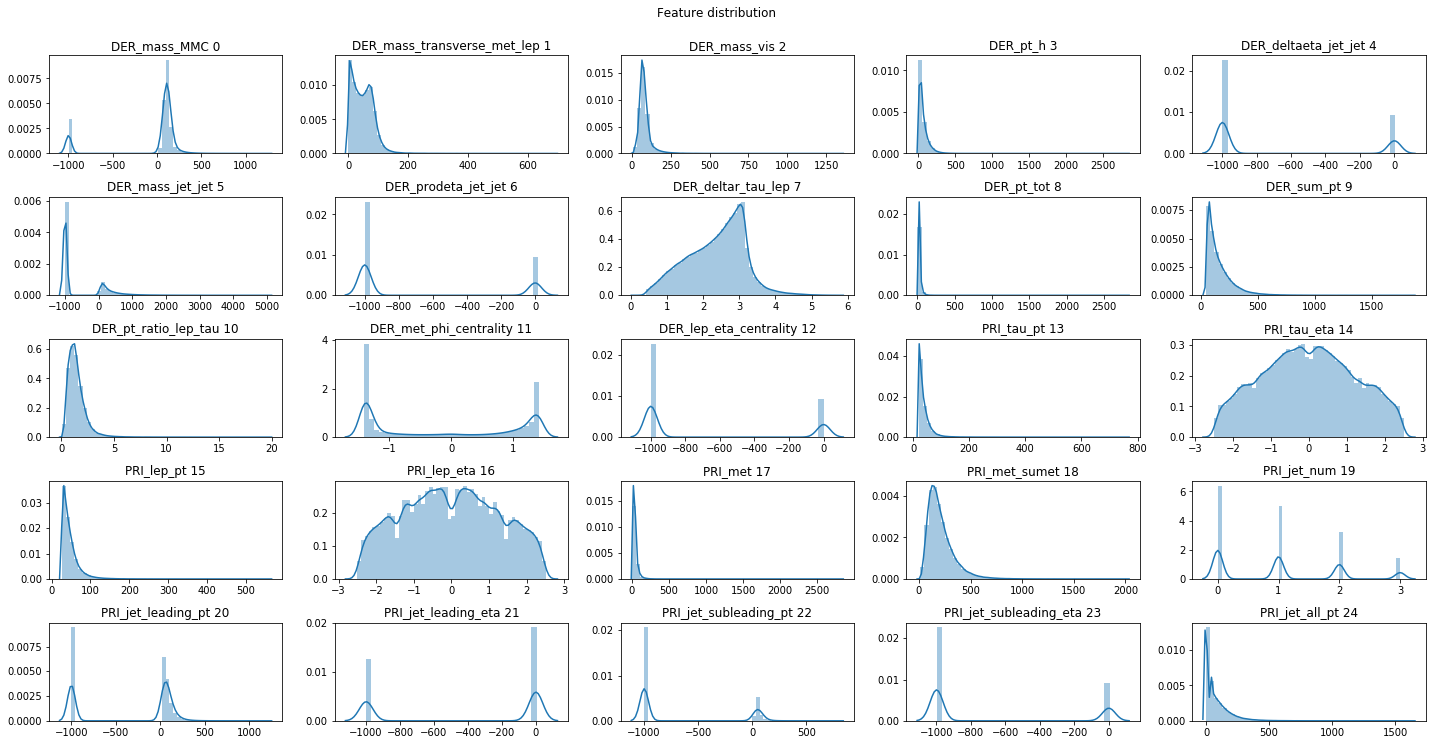

In [84]:
from plots import plot_feature_distribution
to_delete = [15, 18, 20, 25, 28]
to_keep = [x for x in np.arange(tX.shape[1]) if x not in to_delete]
headers = headers[to_keep]
tX = tX[:, to_keep]
plot_feature_distribution(tX, headers, np.arange(tX.shape[1]), "Feature distribution", 5, 5)

For now, we will split the dataset into 6 categories:
- `tX_0, y_0` : Features and labels for experiments with 0 jets, that have a defined `DER_mass_MMC`
- `tX_0_nm,, y_0_nm`:  Features and labels for experiments with 0 jets, that have an undefined `DER_mass_MMC`
- `tX_1, y_1` : Features and labels for experiments with 1 jet, that have a defined `DER_mass_MMC`
- `tX_1_nm, y_1_nm`: Features and labels for experiments with 1 jet, that have an undefined `DER_mass_MMC`
- `tX_2, y_2` : Features and labels for experiments with more than 1 jets
- `tX_2_nm, y_2_nm`: Features and labels for experiments with more than 1 jet, that have an undefined `DER_mass_MMC`

In [85]:
from data_processing import split_dataset

jet_column = 19
mass_col = 0
tX_0, y_0, tX_0_nm, y_0_nm, tX_1, y_1, tX_1_nm, y_1_nm, tX_2, y_2, tX_2_nm, y_2_nm = split_dataset(tX, y, jet_col=jet_column, mass_col=0) # Split into each category

Now that we have split the dataset, we need to select the columns that are meaningful for each category, and add some features using polynomial expansion, exponential, logarithm and so on. For that, we have created a function `enhance_features`. This function adds all the expansions and performs PCA to project the feature matrix on a new basis

In [86]:
from data_processing import prepare_for_training
from implementations import reg_logistic_regression, ridge_regression
from cross_validation import cross_validate_degrees

def train_ridge_model(x, y, train_ratio, cols, lambda_):
    x_train, y_train, x_test, y_test = prepare_for_training(x, y, cols, train_ratio, logistic=False)
    weights, loss = ridge_regression(y_train, x_train, lambda_)

    score = compute_accuracy(y_test, x_test, weights)
    print(f"Ridge regression got score of {score}, loss of {loss}")
    return weights

def train_logistic_model(x, y, train_ratio, cols, gamma, lambda_, max_iters):
    x_train, y_train, x_test, y_test = prepare_for_training(x, y, cols, train_ratio, logistic=True)
    initial_w = np.zeros((x_train.shape[1], 1))
    
    weights, loss = reg_logistic_regression(y_train, x_train, lambda_, initial_w, max_iters, gamma)
    

    score = compute_accuracy(y_test, x_test, weights)
    print(f"Regularized logisitc regression got score of {score}, loss of {loss}")
    return weights

#### A few global variable declarations

In [87]:
from feature_expansion import expand_features

In [88]:
train_ratio = 0.9

### Category 0

In [ ]:
cross_validate_degrees(tX_0, y_0, 1e-2,1e-5, np.arange(1, 7), 4, "Mean accuracy w.r. to polynomial expansion for PRI_jet_num=0, DER_MASS_MMC > -999")

As we can see, a degree of 7 gives the highest accuracy

In [ ]:
cross_validate_reg(tX_0_exp, y_0, selected_cols_0, 1e-5, np.logspace(-4, 0, 5), 4, "Mean accuracy and Loss w.r. to Regularization for PRI_jet_num=0, DER_MASS_MMC > -999")

In [11]:
from feature_expansion import remove_unnecessary_features

In [89]:
remove_unnecessary_features(tX_0, 22)[0].shape

(73790, 15)

In [118]:
degree_0 = 2
tX_0_exp = expand_features(tX_0, degree_0, jet_col=jet_column)
w_0 = train_logistic_model(tX_0_exp, y_0, train_ratio, None, 1e-5, 0, 1000)#train_ridge_model(tX_0_exp, y_0, train_ratio, None, 1e-2)

Performing polynomial expansion up to degree 2
Matrix has now 54 features
Gradient Descent(0/999): loss=46032.597408166526
Gradient Descent(100/999): loss=28835.14457568583
Gradient Descent(200/999): loss=28675.1673970879
Gradient Descent(300/999): loss=28607.86236908528
Gradient Descent(400/999): loss=28558.825186994804
Gradient Descent(500/999): loss=28518.7021924848
Gradient Descent(600/999): loss=28484.62009156763
Gradient Descent(700/999): loss=28455.063426790643
Gradient Descent(800/999): loss=28429.05237675696
Gradient Descent(900/999): loss=28405.904191885464
Regularized logisitc regression got score of 0.8078330397072774, loss of 28385.127212323983


### Category 0, no mass defined

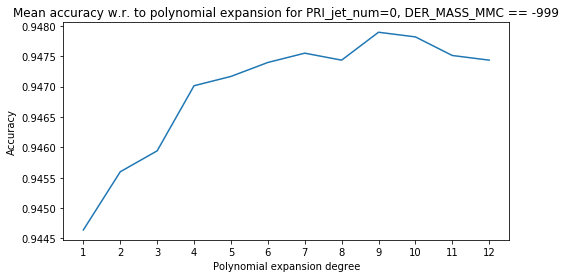

In [67]:
cross_validate_degrees(tX_0_nm, y_0_nm, 1e-4, np.arange(1, 13), 4, "Mean accuracy w.r. to polynomial expansion for PRI_jet_num=0, DER_MASS_MMC == -999")

In [119]:
degree_0_nm = 2
tX_0_nm_exp = expand_features(tX_0_nm, degree_0_nm, jet_col=jet_column)
w_0_nm = train_logistic_model(tX_0_nm_exp, y_0_nm, train_ratio, None, 1e-5, 0, 1000)#train_ridge_model(tX_0_nm_exp, y_0_nm, train_ratio, None, 1e-2)

Performing polynomial expansion up to degree 2
Matrix has now 50 features
Gradient Descent(0/999): loss=16295.890214964315
Gradient Descent(100/999): loss=4186.75507806028
Gradient Descent(200/999): loss=3934.8082613469946
Gradient Descent(300/999): loss=3871.991560425073
Gradient Descent(400/999): loss=3845.103994782494
Gradient Descent(500/999): loss=3829.317618984218
Gradient Descent(600/999): loss=3818.0634798113692
Gradient Descent(700/999): loss=3809.107518618399
Gradient Descent(800/999): loss=3801.532055740851
Gradient Descent(900/999): loss=3794.892895374354
Regularized logisitc regression got score of 0.951396861844623, loss of 3788.9414992740544


### Category 1

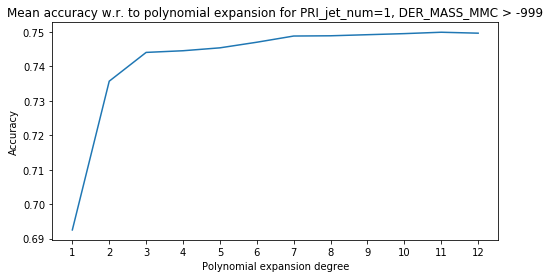

In [122]:
cross_validate_degrees(tX_1, y_1, 1e-2, np.arange(1, 13), 4, "Mean accuracy w.r. to polynomial expansion for PRI_jet_num=1, DER_MASS_MMC > -999")

In [130]:
degree_1 = 2
tX_1_exp = expand_features(tX_1, degree_1, jet_col=jet_column)
w_1 = train_logistic_model(tX_1_exp, y_1, train_ratio, None, 1e-5, 0, 1000)#train_ridge_model(tX_1_exp, y_1, train_ratio, None, 1e-4)

Performing polynomial expansion up to degree 2
Matrix has now 64 features
Gradient Descent(0/999): loss=43656.48887320703
Gradient Descent(100/999): loss=31184.43094529122
Gradient Descent(200/999): loss=30395.17123802624
Gradient Descent(300/999): loss=29998.504529929454
Gradient Descent(400/999): loss=29782.407416107213
Gradient Descent(500/999): loss=29693.791514394143
Gradient Descent(600/999): loss=29647.64813016973
Gradient Descent(700/999): loss=29612.394094738207
Gradient Descent(800/999): loss=29583.602134849145
Gradient Descent(900/999): loss=29558.98252786466
Regularized logisitc regression got score of 0.78511215887984, loss of 29537.219632412627


### Category 1, no mass defined

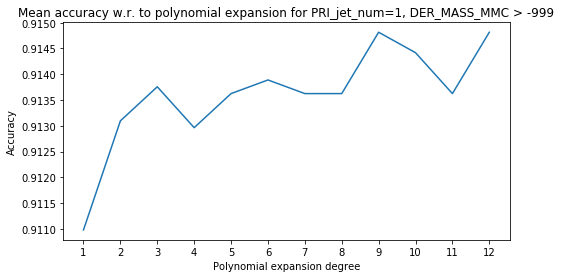

In [117]:
cross_validate_degrees(tX_1_nm, y_1_nm, 1e-2, np.arange(1, 13), 4, "Mean accuracy w.r. to polynomial expansion for PRI_jet_num=1, DER_MASS_MMC > -999")

In [141]:
degree_1_nm = 2
tX_1_nm_exp = expand_features(tX_1_nm, degree_1_nm, jet_col=jet_column)
w_1_nm = train_logistic_model(tX_1_nm_exp, y_1_nm, train_ratio, None, 1e-5, 0, 1000)#train_ridge_model(tX_1_nm_exp, y_1_nm, train_ratio, None, 1e-2)

Performing polynomial expansion up to degree 2
Matrix has now 60 features
Gradient Descent(0/999): loss=4716.866563710428
Gradient Descent(100/999): loss=2070.8668591862206
Gradient Descent(200/999): loss=1781.334233043237
Gradient Descent(300/999): loss=1696.206904621122
Gradient Descent(400/999): loss=1658.6583493598407
Gradient Descent(500/999): loss=1637.8872930363545
Gradient Descent(600/999): loss=1624.6551141928576
Gradient Descent(700/999): loss=1615.3975686435776
Gradient Descent(800/999): loss=1608.4846859924796
Gradient Descent(900/999): loss=1603.0735461348477
Regularized logisitc regression got score of 0.916776750330251, loss of 1598.685919754022


### Category 2

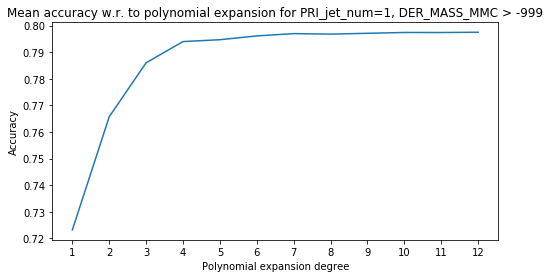

In [80]:
cross_validate_degrees(tX_2, y_2, 1e-4, np.arange(1, 13), 4, "Mean accuracy w.r. to polynomial expansion for PRI_jet_num=1, DER_MASS_MMC > -999")

In [150]:
degree_2 = 2
tX_2_exp = expand_features(tX_2, degree_2, jet_col=jet_column)
w_2 = train_logistic_model(tX_2_exp, y_2, train_ratio, None, 1e-5, 0, 1000)#train_ridge_model(tX_2_exp, y_2, train_ratio, None, 1e-4)

Performing polynomial expansion up to degree 2
Matrix has now 84 features
Gradient Descent(0/999): loss=42491.30846268577
Gradient Descent(100/999): loss=27672.11606489292
Gradient Descent(200/999): loss=26858.799712716154
Gradient Descent(300/999): loss=26588.555821493464
Gradient Descent(400/999): loss=26444.7121317028
Gradient Descent(500/999): loss=26355.371896237368
Gradient Descent(600/999): loss=26293.357791043534
Gradient Descent(700/999): loss=26246.555169606123
Gradient Descent(800/999): loss=26208.9305034032
Gradient Descent(900/999): loss=26177.227075253497
Regularized logisitc regression got score of 0.8128302994715209, loss of 26149.57377849167


### Category 2, no mass defined

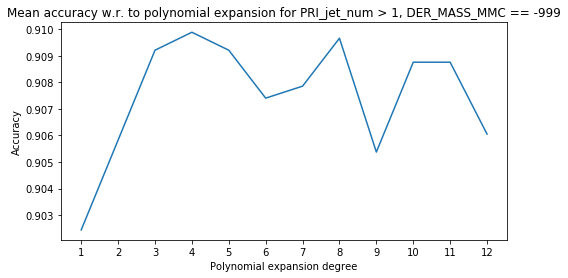

In [89]:
cross_validate_degrees(tX_2_nm, y_2_nm, 1e-4, np.arange(1, 13), 4, "Mean accuracy w.r. to polynomial expansion for PRI_jet_num > 1, DER_MASS_MMC == -999")

In [161]:
degree_2_nm = 2
tX_2_nm_exp = expand_features(tX_2_nm, degree_2_nm, jet_col=jet_column)
w_2_nm = train_logistic_model(tX_2_nm_exp, y_2_nm, train_ratio, None, 1e-5, 0, 1000)#train_ridge_model(tX_2_nm_exp, y_2_nm, train_ratio, None, 1e-4)

Performing polynomial expansion up to degree 2
Matrix has now 80 features
Gradient Descent(0/999): loss=2762.884661711942
Gradient Descent(100/999): loss=1445.8019547623067
Gradient Descent(200/999): loss=1197.4516460343675
Gradient Descent(300/999): loss=1106.4204156825278
Gradient Descent(400/999): loss=1062.7547130777018
Gradient Descent(500/999): loss=1037.9665808257075
Gradient Descent(600/999): loss=1022.1871773531064
Gradient Descent(700/999): loss=1011.284552282885
Gradient Descent(800/999): loss=1003.275137084006
Gradient Descent(900/999): loss=997.1008391743978
Regularized logisitc regression got score of 0.909706546275395, loss of 992.1499132667276


## Generate predictions and save ouput in csv format for submission:

In [102]:
from data_processing import prepare_for_testing

In [103]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test, _ = load_csv_data(DATA_TEST_PATH)

In [104]:
tX_test = tX_test[:, to_keep]

In [105]:
np.unique(tX_test[:, jet_column])

array([0., 1., 2., 3.])

In [106]:
def predict_testset(x, h, degrees, cols, w):
    x = expand_features(x, degrees, print_=False, jet_col=jet_column)
    x = prepare_for_testing(x, logistic=True)
    print(x.shape)
    #x = x[:, cols]
    y_pred = predict_labels(w, x)
    return y_pred

In [107]:
tX_0_test, ids_0, tX_0_nm_test, ids_0_nm, tX_1_test, ids_1, tX_1_nm_test, ids_1_nm, tX_2_test, ids_2, tX_2_nm_test, ids_2_nm = split_dataset(tX_test, ids_test, jet_col=jet_column, mass_col=0) # Split into each category

In [151]:
y_pred_0 = predict_testset(tX_0_test, headers, degree_0, None, w_0)
y_pred_0_nm = predict_testset(tX_0_nm_test, headers, degree_0_nm, None, w_0_nm)

(168195, 55)
(59263, 51)


In [152]:
y_pred_1 = predict_testset(tX_1_test, headers, degree_1, None, w_1)
y_pred_1_nm = predict_testset(tX_1_nm_test, headers, degree_1_nm, None, w_1_nm)

(158095, 65)
(17243, 61)


In [162]:
y_pred_2 = predict_testset(tX_2_test, headers, degree_2, None, w_2)
y_pred_2_nm = predict_testset(tX_2_nm_test, headers, degree_2_nm, None, w_2_nm)

(155460, 85)
(9982, 81)


In [163]:
ids_test = np.concatenate([ids_0, ids_0_nm, ids_1, ids_1_nm, ids_2, ids_2_nm])
y_pred = np.concatenate([y_pred_0, y_pred_0_nm, y_pred_1, y_pred_1_nm, y_pred_2, y_pred_2_nm])

In [164]:
y_pred.shape[0] == tX_test.shape[0]

True

In [165]:
OUTPUT_PATH = 'submission.csv' # TODO: fill in desired name of output file for submission
#y_pred = predict_labels(weights_ridge, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [166]:
import pandas as pd

In [167]:
labels = pd.read_csv('../data/solution-with-features.csv')[['Id', 'Prediction']]
pred = pd.read_csv('submission.csv')

In [168]:
c = pred.merge(labels, on='Id')

In [169]:
len(c[c['Prediction_x'] == c['Prediction_y']]) / len(pred)

0.8214656534761843

In [249]:
len(c[c['Prediction_x'] == c['Prediction_y']]) / len(pred)

0.8214779722581032